Demonstration for how to use `libst.SolverProxy` to prototype a solver in Python.

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import libst

This is a class derived from `libst.SolverProxy` that allows to use Python to define the physical process to be calculated using the space-time CESE method:

In [2]:
class LinearProxy(libst.SolverProxy):

    # These are the call-back functions for physical calculations.
    def _xn_calc(self, se, iv):
        displacement = 0.5 * (se.x + se.xneg) - se.xctr
        return se.dxneg * (se.get_so0(iv) + displacement * se.get_so1(iv))

    def _xp_calc(self, se, iv):
        displacement = 0.5 * (se.x + se.xpos) - se.xctr
        return se.dxpos * (se.get_so0(iv) + displacement * se.get_so1(iv))

    def _tn_calc(self, se, iv):
        displacement = se.x - se.xctr
        ret = se.get_so0(iv)  # f(u)
        ret += displacement * se.get_so1(iv)  # displacement in x; f_u == 1
        ret += se.qdt * se.get_so1(iv)  # displacement in t
        return se.hdt * ret

    def _tp_calc(self, se, iv):
        displacement = se.x - se.xctr
        ret = se.get_so0(iv)  # f(u)
        ret += displacement * se.get_so1(iv)  # displacement in x; f_u == 1
        ret -= se.qdt * se.get_so1(iv)  # displacement in t
        return se.hdt * ret

    def _so0p_calc(self, se, iv):
        ret = se.get_so0(iv)
        ret += (se.x-se.xctr) * se.get_so1(iv)  # displacement in x
        ret -= se.hdt * se.get_so1(iv)  # displacement in t
        return ret

    def _cfl_updater(self, se):
        hdx = min(se.dxneg, se.dxpos)
        se.set_cfl(se.hdt / hdx)

Initialize a solver (proxy) object and use it to calculate the propagating wave.

**Step 1**: Create the grid.

In [3]:
grid = libst.Grid(0, 4*2*np.pi, 4*64)

**Step 2**: Create the solver.

In [4]:
cfl = 1
dx = (grid.xmax - grid.xmin) / grid.ncelm
dt = dx * cfl
svr = LinearProxy(grid=grid, time_increment=dt, nvar=1)

**Step 3**: Initialize the field.

In [5]:
def initialize(svr):
    svr.so0.ndarray.fill(0)
    svr.so1.ndarray.fill(0)
    for e in svr.selms(odd_plane=False):
        if e.xctr < 2*np.pi or e.xctr > 2*2*np.pi:
            v = 0
            dv = 0
        else:
            v = np.sin(e.xctr)
            dv = np.cos(e.xctr)
        e.set_so0(0, v)
        e.set_so1(0, dv)

initialize(svr)

After getting the solver object `svr` initialized, we can show the initial field of the wave.

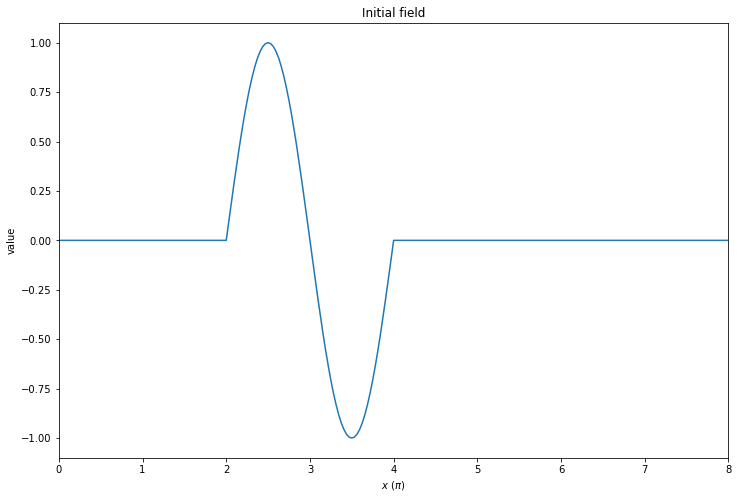

In [6]:
plt.figure(figsize=(12,8))
plt.xlim((0, 8))
plt.xlabel('$x$ ($\pi$)')
plt.ylabel('value')
plt.title('Initial field')

plt.plot(svr.xctr() / np.pi, svr.get_so0(0).ndarray, '-')

Show propagating wave.

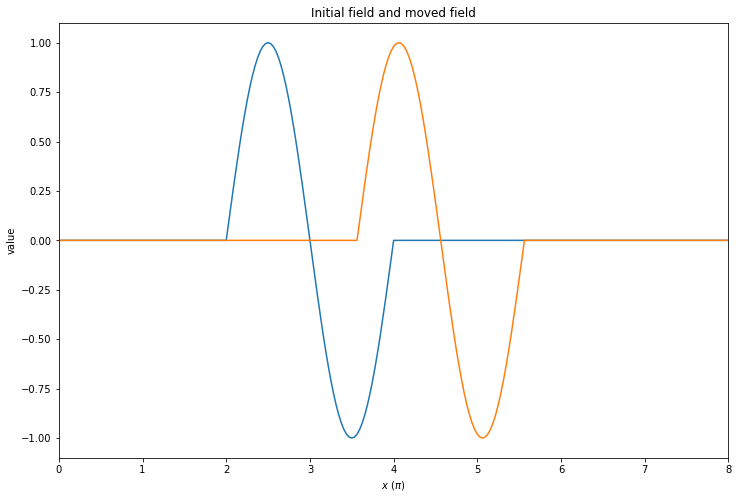

In [7]:
plt.figure(figsize=(12,8))
plt.xlim((0, 8))
plt.xlabel('$x$ ($\pi$)')
plt.ylabel('value')
plt.title('Initial field and moved field')

plt.plot(svr.xctr() / np.pi, svr.get_so0(0).ndarray, '-')

# Time march
svr.setup_march()
svr.march_alpha2(50)

plt.plot(svr.xctr() / np.pi, svr.get_so0(0).ndarray, '-')

# Better proxy

Since `LinearProxy` is a fully-fledged Python class, we can make it more useful.  All the related code can be organized into the class.

In [8]:
class BetterLinearProxy(libst.SolverProxy):
    
    def __init__(self):
        grid = libst.Grid(0, 4*2*np.pi, 4*64)
        cfl = 1
        dx = (grid.xmax - grid.xmin) / grid.ncelm
        dt = dx * cfl
        libst.SolverProxy.__init__(self, grid=grid, time_increment=dt, nvar=1)
        self.initialize()
        
    def initialize(self):
        svr = self.svr
        svr.so0.ndarray.fill(0)
        svr.so1.ndarray.fill(0)
        for e in svr.selms(odd_plane=False):
            if e.xctr < 2*np.pi or e.xctr > 2*2*np.pi:
                v = 0
                dv = 0
            else:
                v = np.sin(e.xctr)
                dv = np.cos(e.xctr)
            e.set_so0(0, v)
            e.set_so1(0, dv)

    @property
    def xctr_pi(self):
        return self.xctr() / np.pi

    @property
    def value(self):
        return self.svr.get_so0(0).ndarray.copy()

    # These are the call-back functions for physical calculations.
    def _xn_calc(self, se, iv):
        displacement = 0.5 * (se.x + se.xneg) - se.xctr
        return se.dxneg * (se.get_so0(iv) + displacement * se.get_so1(iv))

    def _xp_calc(self, se, iv):
        displacement = 0.5 * (se.x + se.xpos) - se.xctr
        return se.dxpos * (se.get_so0(iv) + displacement * se.get_so1(iv))

    def _tn_calc(self, se, iv):
        displacement = se.x - se.xctr
        ret = se.get_so0(iv)  # f(u)
        ret += displacement * se.get_so1(iv)  # displacement in x; f_u == 1
        ret += se.qdt * se.get_so1(iv)  # displacement in t
        return se.hdt * ret

    def _tp_calc(self, se, iv):
        displacement = se.x - se.xctr
        ret = se.get_so0(iv)  # f(u)
        ret += displacement * se.get_so1(iv)  # displacement in x; f_u == 1
        ret -= se.qdt * se.get_so1(iv)  # displacement in t
        return se.hdt * ret

    def _so0p_calc(self, se, iv):
        ret = se.get_so0(iv)
        ret += (se.x-se.xctr) * se.get_so1(iv)  # displacement in x
        ret -= se.hdt * se.get_so1(iv)  # displacement in t
        return ret

    def _cfl_updater(self, se):
        hdx = min(se.dxneg, se.dxpos)
        se.set_cfl(se.hdt / hdx)

Calculate and plot the results.  The plotting code becomes neater.

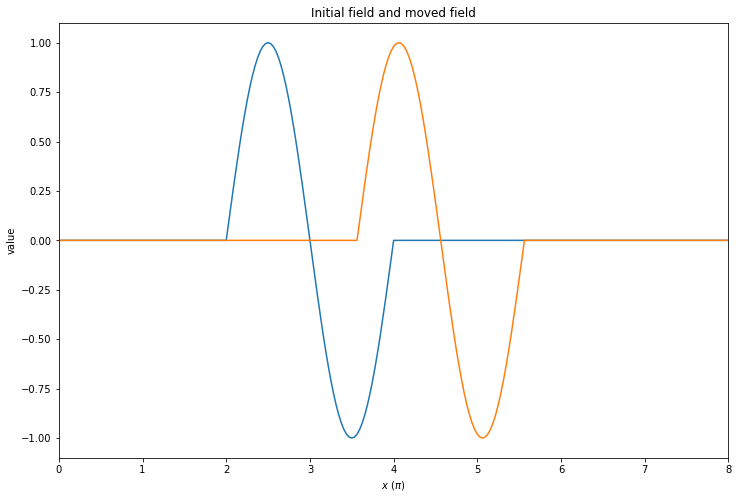

In [9]:
plt.figure(figsize=(12,8))
plt.xlim((0, 8))
plt.xlabel('$x$ ($\pi$)')
plt.ylabel('value')
plt.title('Initial field and moved field')

svr2 = BetterLinearProxy()
plt.plot(svr2.xctr_pi, svr2.value, '-')

# Time march
svr2.setup_march()
svr2.march_alpha2(50)

plt.plot(svr2.xctr_pi, svr2.value, '-')